In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\Fig4"

In [3]:
pdry = 0.21
pcarbon = 0.5
CUE = 0.5
density = 1.1 #g.cm-3
C_factor = pdry * pcarbon/CUE*density #g.cm-3
C_factor_volume = C_factor /0.9 #cm3.cm-3
v0 = 3 #um.s-1
C_factor_flux = C_factor_volume/v0 #s.um-1

In [4]:
C_factor_volume

0.25666666666666665

In [5]:
nodes_source = [3,0]
nodes_sink = [6,7]

In [158]:
def create_G(length_init):
    # Create an empty graph
    G = nx.Graph()

    # Add 6 nodes
    G.add_nodes_from(range(8))

    # Manually set positions for a 3x2 lattice
    positions = {0: (1000, 0), 1: (1000, length_init), 2: (1000, length_init+1000),
                 3: (0, 0), 4: (0, length_init), 5: (0, length_init+1000),6:(0,length_init+2000),7:(1000,length_init+2000)}

    # Add edges between adjacent nodes
    edges = [(0, 1), (1, 2),  # edges in the top row
             (3, 4), (4, 5),  # edges in the bottom row
            (1, 4),(5,6),(2,7),(2,5)]  # vertical edges connecting rows

    # Add edges to the graph
    G.add_edges_from(edges)
    return(G,positions)

In [159]:
def add_attributes(G,length_init = 1000,ratio = 0.5):
    for edge in G.edges:
        G[edge[0]][edge[1]]["radius"] = 3 #um
        G[edge[0]][edge[1]]["length"] = 1000 #um

        G[edge[0]][edge[1]]['v0'] = 0
    G[0][1]["length"] = length_init
    G[3][4]["length"] = length_init
    tot_cross_section = 2*3**2
    G[3][4]["radius"] = np.sqrt(tot_cross_section*ratio)
    G[0][1]["radius"] = np.sqrt(tot_cross_section*(1-ratio))    

In [160]:
def add_heaton_flux(G,ratio = 0.1,tot_growth = 20):
    ext_flows_out = {6 : tot_growth/2, 7 : tot_growth/2}
    ext_flows_in = {3 : -ratio*tot_growth, 0:-(1-ratio)*tot_growth}
    DG = convert_to_directed(G)
    for node in nodes_sink:
        ext_flows_in[node] = 0
    tot_flow = np.sum(list(ext_flows_in.values()))
    ext_flows = {**ext_flows_in, **ext_flows_out}
    A, b = build_matrix_system(DG, ext_flows)
    flows = solve_flows(A, b)
    edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
    nx.set_edge_attributes(G, edge_flows, "water_flux_heaton")
    for edge in G.edges:
        G[edge[0]][edge[1]]["water_flux_heaton_abs"] = abs(G[edge[0]][edge[1]]["water_flux_heaton"])
        G[edge[0]][edge[1]]["speed_heaton"] = G[edge[0]][edge[1]]["water_flux_heaton"] / (np.pi * G[edge[0]][edge[1]]["radius"] ** 2)

In [161]:
def add_heaton_flux2(G,ratio = 0.5,tot_growth = 20):
    ext_flows_out = {6 : tot_growth/2, 7 : tot_growth/2}
    ext_flows_in = {3 : -ratio*tot_growth, 0:-(1-ratio)*tot_growth}
    DG = convert_to_directed(G)
    for node in nodes_sink:
        ext_flows_in[node] = 0
    tot_flow = np.sum(list(ext_flows_in.values()))
    ext_flows = {**ext_flows_in, **ext_flows_out}
    A, b = build_matrix_system(DG, ext_flows)
    flows = solve_flows(A, b)
    edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
    nx.set_edge_attributes(G, edge_flows, "water_flux_heaton2")
    for edge in G.edges:
        G[edge[0]][edge[1]]["water_flux_heaton_abs2"] = abs(G[edge[0]][edge[1]]["water_flux_heaton2"])
        G[edge[0]][edge[1]]["speed_heaton2"] = G[edge[0]][edge[1]]["water_flux_heaton2"] / (np.pi * G[edge[0]][edge[1]]["radius"] ** 2)

In [162]:
tanh_steepness = 10#s.um-1
def add_backflow(G):

    lipid_fraction = 0.1 
    for edge in G.edges:
        G[edge[0]][edge[1]]["tot_cross_section"] = np.pi * G[edge[0]][edge[1]]["radius"]**2
        G[edge[0]][edge[1]]["lipid_phase_fraction"] = np.abs(G[edge[0]][edge[1]]["speed_heaton"]) * C_factor_flux / lipid_fraction
        G[edge[0]][edge[1]]["lipid_cross_section"] = G[edge[0]][edge[1]]["lipid_phase_fraction"]*G[edge[0]][edge[1]]["tot_cross_section"]
        assert(G[edge[0]][edge[1]]["lipid_phase_fraction"]<1)
        assert(G[edge[0]][edge[1]]["lipid_phase_fraction"]>=0)

        G[edge[0]][edge[1]]["water_cross_section"] = (1-G[edge[0]][edge[1]]["lipid_phase_fraction"])*G[edge[0]][edge[1]]["tot_cross_section"]
        G[edge[0]][edge[1]]["water_phase_radius"] = np.sqrt((G[edge[0]][edge[1]]["water_cross_section"] /np.pi))

        G[edge[0]][edge[1]]['v0'] = np.tanh(tanh_steepness*G[edge[0]][edge[1]]['speed_heaton'])*v0
        
        G[edge[0]][edge[1]]["net_water_flux_phase_lipid"] = G[edge[0]][edge[1]]["lipid_cross_section"]*G[edge[0]][edge[1]]['v0']*(1-lipid_fraction)
    DG = convert_to_directed(G,radius_attribute = "water_phase_radius")
    for node in (nodes_source):
        DG.add_edge(node, "ground", length=0, radius=2, v0=0, Res=0, pot=0)  # Add edge back to the root


    ext_flows = {}
    A, b = build_matrix_system(DG, ext_flows)
    flows = solve_flows(A, b)
    edge_flows = {edge: flow for edge, flow in zip(DG.edges(), flows)}
    nx.set_edge_attributes(G, edge_flows, "net_water_flux_phase")
    for edge in G.edges:
        G[edge[0]][edge[1]]["net_water_flux_phase_abs"] = abs(G[edge[0]][edge[1]]["net_water_flux_phase"])
        G[edge[0]][edge[1]]["net_water_flux_phase_backflow"] = G[edge[0]][edge[1]]["net_water_flux_phase"]+G[edge[0]][edge[1]]["water_flux_heaton2"]-G[edge[0]][edge[1]]["net_water_flux_phase_lipid"]
        # -G[edge[0]][edge[1]]['v0']*G[edge[0]][edge[1]]["water_cross_section"]/2
        G[edge[0]][edge[1]]["speed_backflow_phase"] = 2*G[edge[0]][edge[1]]["net_water_flux_phase_backflow"] / G[edge[0]][edge[1]]["water_cross_section"]

In [163]:
def convert_to_directed(undirected_graph,orientation_attribute=None,radius_attribute = 'radius'):
    # Create a new directed graph
    directed_graph = nx.DiGraph()

    # Define constant values for dynamic viscosity (mu)
    mu = 1e-3  #kg.m-1.s-1
    mu = mu * 1e-6 #kg.um-1.s-1 (but doesn't really have consequences
    # until compared with aquaporin porosity)

    # Add edges to the directed graph with direction based on node label ordering
    for u, v, attr in undirected_graph.edges(data=True):
        orientation_tot =(1-2*(u>v))
        if not orientation_attribute is None:
            orientation_tot *= (2*(attr[orientation_attribute]>0)-1)
        if orientation_tot==1:
            directed_graph.add_edge(u, v, **attr)
        else:
            directed_graph.add_edge(v, u, **attr)

    # Calculate the resistance and potential for each edge in the directed graph
    for u, v, attr in directed_graph.edges(data=True):
        # attr['radius'] = max(attr['width'] / 2, 0.5)
        # attr['v0'] = np.sign(attr['QBC_net'])*3 if abs(attr['QBC_net'])>0 else 0
        attr['Res'] = 8 * mu * attr["length"] / (np.pi * attr[radius_attribute] ** 4)
        if radius_attribute == "water_phase_radius":
            attr['pot'] = 8 * mu * attr["length"] * attr['v0'] / (np.pi * attr[radius_attribute] ** 2)+attr['Res']*attr['net_water_flux_phase_lipid']
            # attr['pot'] = 8 * mu * attr["length"] * attr['v0'] / (np.pi * attr[radius_attribute] ** 2)
        
        else:
            attr['pot'] = 8 * mu * attr["length"] * attr['v0'] / (np.pi * attr[radius_attribute] ** 2)

    return directed_graph

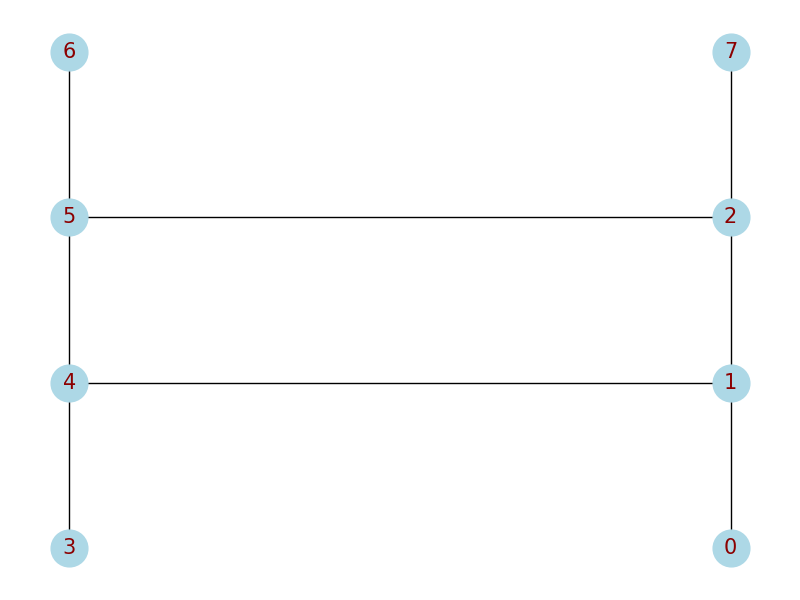

In [165]:
length_init = 1000
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
G,positions = create_G(length_init)
# Draw the graph with labels and specified node positions
nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=700, font_size=15, font_color='darkred')
plt.show()


In [166]:
ratio = 0.2
add_attributes(G,length_init = length_init,ratio=0.2)
add_heaton_flux(G,ratio = ratio,tot_growth = 30)
add_heaton_flux2(G,ratio = 0.5,tot_growth = 30)
add_backflow(G)

In [167]:
G[0][1]

{'radius': 3.794733192202055,
 'length': 1000,
 'v0': 2.9998520438674596,
 'water_flux_heaton': 24.0,
 'water_flux_heaton_abs': 24.0,
 'speed_heaton': 0.5305164769729845,
 'water_flux_heaton2': 15.0,
 'water_flux_heaton_abs2': 15.0,
 'speed_heaton2': 0.33157279810811535,
 'tot_cross_section': 45.238934211693014,
 'lipid_phase_fraction': 0.4538863191879978,
 'lipid_cross_section': 20.53333333333333,
 'water_cross_section': 24.705600878359682,
 'water_phase_radius': 2.804289037116686,
 'net_water_flux_phase_lipid': 55.43726577067065,
 'net_water_flux_phase': -10.212471415642081,
 'net_water_flux_phase_abs': 10.212471415642081,
 'net_water_flux_phase_backflow': -50.649737186312734,
 'speed_backflow_phase': -4.100263534223791}

In [168]:
G[3][4]

{'radius': 1.8973665961010275,
 'length': 1000,
 'v0': 2.9998520438674596,
 'water_flux_heaton': 6.0,
 'water_flux_heaton_abs': 6.0,
 'speed_heaton': 0.5305164769729845,
 'water_flux_heaton2': 15.0,
 'water_flux_heaton_abs2': 15.0,
 'speed_heaton2': 1.3262911924324614,
 'tot_cross_section': 11.309733552923253,
 'lipid_phase_fraction': 0.4538863191879978,
 'lipid_cross_section': 5.133333333333333,
 'water_cross_section': 6.176400219589921,
 'water_phase_radius': 1.402144518558343,
 'net_water_flux_phase_lipid': 13.859316442667662,
 'net_water_flux_phase': 10.212471415642083,
 'net_water_flux_phase_abs': 10.212471415642083,
 'net_water_flux_phase_backflow': 11.353154972974423,
 'speed_backflow_phase': 3.676301589707608}

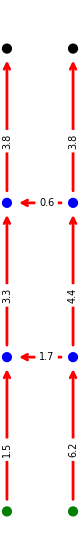

In [169]:

# Drawing the graph with customized edges
plt.figure(figsize=(1*0.8, 7*0.8))
DG = convert_to_directed(G,"water_flux_heaton")
node_colors = ['black' if node in nodes_sink else 'green' if node in nodes_source else 'blue' for node in DG.nodes()]
edge_widths = [2 for flow in nx.get_edge_attributes(DG, 'water_flux_heaton').values()]

nx.draw(DG, pos=positions, with_labels=False, node_color=node_colors,width=0, node_size=40, font_color='red',arrows = False)
edge_labels = nx.get_edge_attributes(DG, 'water_flux_heaton')
edge_labels = {key : "{:.1f}".format(abs(edge_labels[key])*C_factor_volume) for key in edge_labels.keys()}
edges = nx.draw_networkx_edges(DG, pos=positions, width=edge_widths, arrowstyle='->', arrowsize=10, edge_color='red')
label_pos = {e: [(positions[e[0]][0]+positions[e[1]][0])/2, (positions[e[0]][1]+positions[e[1]][1])/2 + 0.1] for e in edge_labels}
nx.draw_networkx_edge_labels(DG, pos = positions,label_pos=0.6, edge_labels=edge_labels, font_color='black',font_size = 7)

plt.savefig(
    os.path.join(path_figure, f"flux_in.pdf"),
    transparent=True,
    bbox_inches="tight")

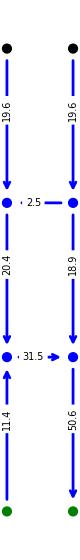

In [170]:
plt.figure(figsize=(1*0.8, 7*0.8))
DG = convert_to_directed(G,"net_water_flux_phase_backflow")
node_colors = ['black' if node in nodes_sink else 'green' if node in nodes_source else 'blue' for node in DG.nodes()]
edge_widths = [2 for flow in nx.get_edge_attributes(DG, 'net_water_flux_phase_backflow').values()]

nx.draw(DG, pos=positions, with_labels=False, node_color=node_colors,width=0, node_size=40, font_color='red',arrows = False)

edges = nx.draw_networkx_edges(DG, pos=positions, width=edge_widths, arrowstyle='->', arrowsize=10, edge_color='blue')
label_pos = {e: [(positions[e[0]][0]+positions[e[1]][0])/2, (positions[e[0]][1]+positions[e[1]][1])/2 + 0.1] for e in edge_labels}
DG = convert_to_directed(G,"water_flux_heaton")
edge_labels = nx.get_edge_attributes(DG, 'net_water_flux_phase_backflow')
edge_labels = {key : "{:.1f}".format(abs(edge_labels[key])) for key in edge_labels.keys()}
nx.draw_networkx_edge_labels(DG, pos = positions,label_pos=0.4, edge_labels=edge_labels, font_color='black',font_size = 7)

plt.savefig(
    os.path.join(path_figure, f"flux_out.pdf"),
    transparent=True,
    bbox_inches="tight")

In [173]:
def get_backflow(ratio,length_init,cross_section_ratio=0.5):
    G,positions = create_G(length_init)
    add_attributes(G,length_init,cross_section_ratio)
    add_heaton_flux(G,ratio,30)
    add_heaton_flux2(G,ratio = 0.5,tot_growth = 30)
    add_backflow(G)
    plant1 = G[0][1]
    plant2 = G[3][4]    
    fluxin1 = G[0][1]["water_flux_heaton"]
    fluxin2 = G[3][4]["water_flux_heaton"]
    fluxout1 = G[0][1]["net_water_flux_phase_backflow"]
    fluxout2 = G[3][4]["net_water_flux_phase_backflow"]
    # print(fluxin1,fluxin2,fluxout1,fluxout2)
    return((fluxin2-fluxin1)/(fluxin2+fluxin1),-(fluxout1-fluxout2)/(fluxout1+fluxout2))

In [174]:
get_backflow(0.2,length_init,0.2)

(-0.6, -1.577818951853826)

In [175]:
ratios = np.linspace(0.1,0.9,100)
# backflow_ratios0 = [get_backflow(ratio,1000)[1] for ratio in ratios]
backflow_ratios = [get_backflow(ratio,length_init,ratio)[1] for ratio in ratios]
inflow_ratios = [get_backflow(ratio,length_init,ratio)[0] for ratio in ratios]
backflow_ratios2 = [get_backflow(ratio,length_init)[1] for ratio in ratios]
inflow_ratios2 = [get_backflow(ratio,length_init)[0] for ratio in ratios]
# backflow_ratios2 = [get_backflow(ratio,10000)[1] for ratio in ratios]

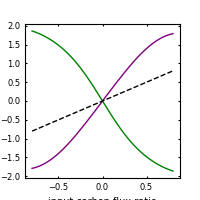

In [176]:
fig,ax = plt.subplots(figsize=(2,2))
ax.plot(inflow_ratios,backflow_ratios,color = "purple")
ax.plot(inflow_ratios2,backflow_ratios2,color = "green")

ax.plot(inflow_ratios,inflow_ratios,color="black",linestyle = "dashed")
ax.set_xlabel("input carbon flux ratio")
ax.set_ylabel("output phoshphorous flux ratio")

plt.savefig(
    os.path.join(path_figure, f"ratio_relationship.pdf"),
    transparent=True,
    bbox_inches="tight")

In [177]:
P_fraction = 0.25 
def get_backflow2(carbon_flux):
    G,positions = create_G(length_init)
    add_attributes(G,5000)
    add_heaton_flux(G,0.5,tot_growth = carbon_flux)
    add_heaton_flux2(G,ratio = 0.5,tot_growth = carbon_flux)
    
    add_backflow(G)
    plant1 = G[0][1]
    fluxin = G[0][1]["water_flux_heaton"]
    fluxout = G[0][1]["net_water_flux_phase_backflow"]
    # print(fluxin1,fluxin2,fluxout1,fluxout2)
    return(fluxin*C_factor*1e-12*3600*1e6*24,-fluxout*1e-12*3600*1e6*24*pdry*density*P_fraction)

In [136]:
CP = pdry*density*P_fraction #g/cm3
CP = CP/31*1e3 #mol/L
CP

1.8629032258064515

In [178]:
Cinputs_raw = np.linspace(1,30,25)
Cinputs = [get_backflow2(Cinput)[0] for Cinput in Cinputs_raw]
Poutputs = [get_backflow2(Cinput)[1] for Cinput in Cinputs_raw]

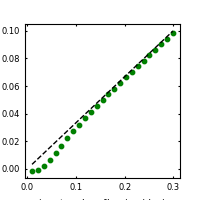

In [179]:
fig,ax = plt.subplots(figsize=(2,2))
ax.scatter(Cinputs,Poutputs,color="green",s=10)
ax.plot(Cinputs,1/3*np.array(Cinputs),color="black",linestyle = "dashed")
ax.set_xlabel("input carbon flux ($\mu g/day$)")
ax.set_ylabel("output phoshporous flux ($\mu g/day$)")

plt.savefig(
    os.path.join(path_figure, f"input_output_relationship.pdf"),
    transparent=True,
    bbox_inches="tight")